In [71]:
import xarray as xr
from windrose import WindroseAxes
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import scipy
import cv2 as cv
from scipy.ndimage import rotate

In [ ]:
def plot_windrose(winddir, windspeeds, bins=np.arange(0, 20, 1), title='Wind gusts (m/s)'):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'windrose'})
    ax.bar(winddir.values, windspeeds.values, bins=bins, normed=True, opening=0.8, edgecolor='white')
    
    # Customize the plot
    ax.set_legend(title=title)
    
    return fig, ax

In [ ]:
def lon_to_180(ds):
    lon = ds["longitude"].where(ds["longitude"] < 180, ds["longitude"] - 360)
    ds = ds.assign_coords(longitude=lon)
    return ds

In [ ]:
# Smear 270m risk to 30m informed by that selected wind rose

In [60]:
def load_angles_dict():
    angles_dict = {}
    angles = np.arange(22.5, 360, 45)
    wind_direction_labels = ['NE', 'N', 'NW', 'W', 'SW', 'S', 'SE', 'E']
    for angle, direction in zip(angles, wind_direction_labels):
        angles_dict[direction] = angle
    return angles_dict

In [61]:
# make the filter based upon the wind direction (directed for now)
def wind_skewed_weights_dict():
    weights_dict = {}
    rotating_angles = np.arange(0, 360, 45)
    wind_direction_labels = ['W', 'SW', 'S', 'SE', 'E', 'NE', 'N', 'NW']
    for angle, direction in zip(rotating_angles, wind_direction_labels):
        weights_dict[direction] = rotate(load_weights(method='wind_skewed'), angle=angle)
        if angle in [45, 135, 225, 315]:
            weights_dict[direction] = weights_dict[direction][17:98, 17:98]
    weights_dict['circular'] = load_weights(method='circular_focal_mean')
    return weights_dict

In [62]:
def load_weights(method='wind_skewed'):
    kernel_size = 81
    circle_diameter = 35
    if method=='circular_focal_mean':
        x, y = np.meshgrid(np.arange(-kernel_size//2 + 1, kernel_size//2 + 1),
                           np.arange(-kernel_size//2 + 1, kernel_size//2 + 1))
        distances = np.sqrt(x**2 + y**2)
        inside = distances <= circle_diameter//2 + 1
        weights = inside / inside.sum()
    elif method=='wind_skewed':
        x, y = np.meshgrid(np.arange(-(kernel_size//2), kernel_size//2 + 1),
                           np.arange(-(kernel_size//2), kernel_size//2 + 1))
        distortion_x = 1.5
        distortion_y = 1/distortion_x
        distances = np.sqrt((x/distortion_x)**2 + (y/distortion_y)**2)
        inside = distances <= circle_diameter//2 
        weights = inside / inside.sum()
        weights = np.roll(weights, -14)
    return weights

In [63]:
def spread_risk_focal_mean(da, iterations=3):
    weights = load_weights(method=method, wind_ds=wind_ds) # if method=='wind_skewed' returns a dictionary
    out = da.values
    for i in np.arange(iterations):
        out =  cv.filter2D(out, -1, weights)
    return out

In [74]:
def spread_risk_wind(da, wind_da, iterations=3):
    # calculate all the different spread options
    all_spreads = all_direction_spreading(da, iterations=iterations)
    # combine with wind_ds to get the wind-tailored spread
    # first load angles dict
    angles_dict = load_angles_dict()
    masked_spreads = xr.Dataset()
    for direction in all_spreads.keys():
        if direction=='E':
            masked_spreads[direction] = all_spreads[direction].where((wind_da<22.5)& (wind_da>337.5))
        # todo add variance threshold
        elif direction=='circular':
            masked_spreads[direction] = all_spreads[direction].where(wind_da.isnull())
        else:
            masked_spreads[direction] = all_spreads[direction].where((wind_da>angles_dict[direction]) & (wind_da<angles_dict[direction]+45))
            
    out_ds = masked_spreads.to_array().sum("variable")
    return out_ds

In [92]:
def all_direction_spreading(da, iterations=3):
    # TODO: add the non-directional spread
    weights_dict = wind_skewed_weights_dict()
    # do the spreading in each of the 8 directions with the correct weights
    out = da.values
    spread_results = xr.zeros_like(da)
    for direction, weights in weights_dict.items():
        for i in np.arange(iterations):
            spread_results[direction] = (da.dims, cv.filter2D(out, -1, weights))
    return spread_results

In [64]:
def subset_region(ds, lon_range, lat_range):
    points = gpd.points_from_xy(lon_range, lat_range, crs="EPSG:4326")
    points = points.to_crs('EPSG:5070')
    region = ds.sel(x=slice(points.x[0], points.x[1]),
               y=slice(points.y[1], points.y[0]))
    return region

In [29]:
def calc_crps(ds):
    return ds['FLP1'] * .25 + \
            ds['FLP2'] * .40 + \
            ds['FLP3'] * .55 + \
            ds['FLP4'] * .70 + \
            ds['FLP5'] * .85 + \
            ds['FLP6'] * 1.

In [30]:
def calc_rps(ds):
    return ds['cRPS'] * ds['BP']

In [ ]:
def gap_fill_270(da):
    da = xr.where(da==0, np.nan, da)
    da = da.rolling({"x":3,"y":3}, center=True, min_periods=1).mean(skipna=True)
    da = da.rolling({"x":3,"y":3}, center=True, min_periods=1).mean(skipna=True)
    da = da.fillna(0)
    return da

In [ ]:
def interpolate_to_30(da, target):
    return da.interp_like(target, kwargs={'fill_value': 'extrapolate',
                                         'bounds_error': False})#, method='cubic')#'pad')#, method='cubic')

In [ ]:
def clean_map():
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks([])
    plt.yticks([])

In [53]:
def interpolate_to_30(da, target):
    return da.interp_like(target, kwargs={'fill_value': 'extrapolate',
                                         'bounds_error': False})#, method='cubic')#'pad')#, method='cubic')

In [ ]:
plt.imshow(load_weights('oval_mean'))
plt.scatter(40,40)

In [ ]:
# Load in 270m risk

In [3]:
historical_path = "s3://carbonplan-risks/riley2025/2011climaterun"
future_path = "s3://carbonplan-risks/riley2025/2047climaterun"
riley = {}
riley['2011'] = xr.open_zarr(historical_path+'.zarr')
riley['2047'] = xr.open_zarr(future_path+'.zarr')

In [31]:
for year, ds in riley.items():
    riley[year]['cRPS']= calc_crps(ds)

In [6]:
lat_min, lat_max = 33.5, 34.5
lon_min, lon_max = -117.6, -116
xy = gpd.points_from_xy([lon_min, lon_max],[lat_min, lat_max], crs="EPSG:4326")
xy = xy.to_crs('EPSG:5070')
x_min, x_max = xy.x.min(), xy.x.max()
y_min, y_max = xy.y.min(), xy.y.max()

In [32]:
fire_name = 'Eaton'
structures = gpd.read_file(f's3://carbonplan-risks/structures/{fire_name}/DINS_2025_{fire_name}_Public_View.shp'.format(fire_name))
structures = structures.to_crs('EPSG:5070')

In [26]:
buffer = 1000
x_min, x_max = structures.geometry.x.min()-buffer, structures.geometry.x.max()+buffer
y_min, y_max = structures.geometry.y.min()-buffer, structures.geometry.y.max()+buffer

In [33]:
subset = riley['2011'].sel(y=slice(y_max,y_min), x=slice(x_min, x_max), band=1)

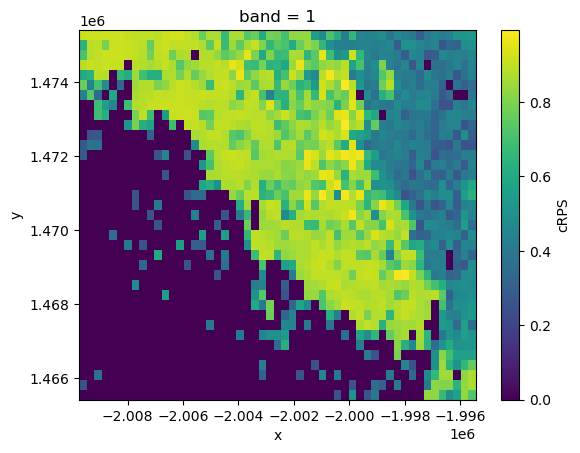

In [39]:
subset['cRPS'].plot()

Text(0.5, 1.0, 'Eaton fire 2025')

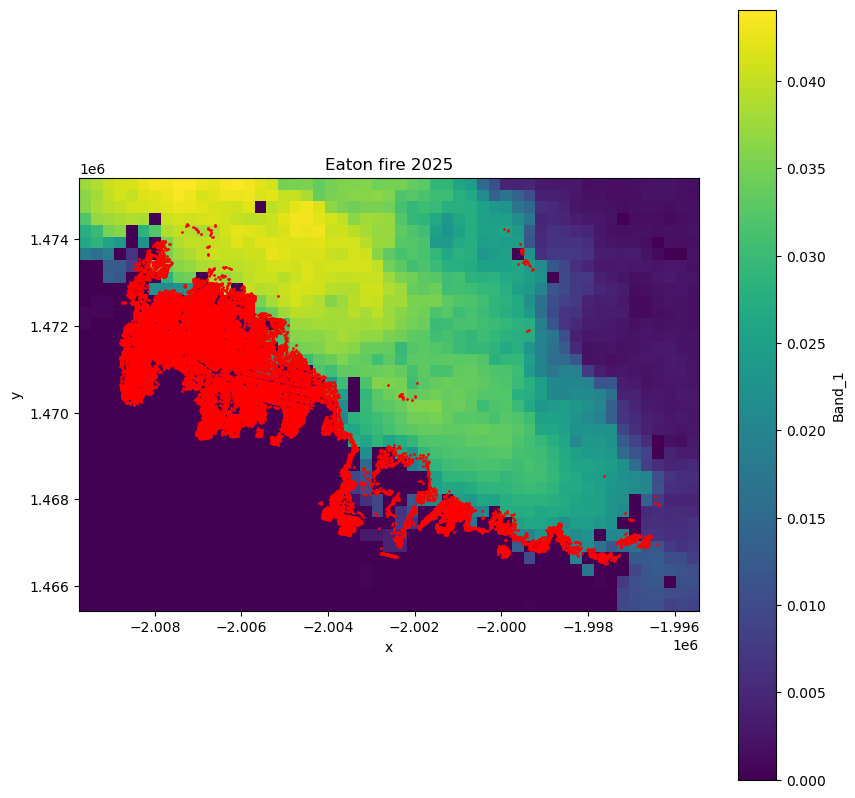

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
subset.BP.plot(ax=ax)
eaton.plot(ax=ax, color='red', markersize=1)
plt.title('Eaton fire 2025')

In [42]:
# load in the 30m product as a template
rps_30 = rioxarray.open_rasterio('s3://carbonplan-risks/wildfirecommunities/RPS_CA.tif')

In [45]:
rps_30 = rps_30.sel(y=slice(y_max,y_min), x=slice(x_min, x_max), band=1)

In [54]:
subset_30 = interpolate_to_30(subset, rps_30)

In [ ]:
# TODO - prevent it from going below zero

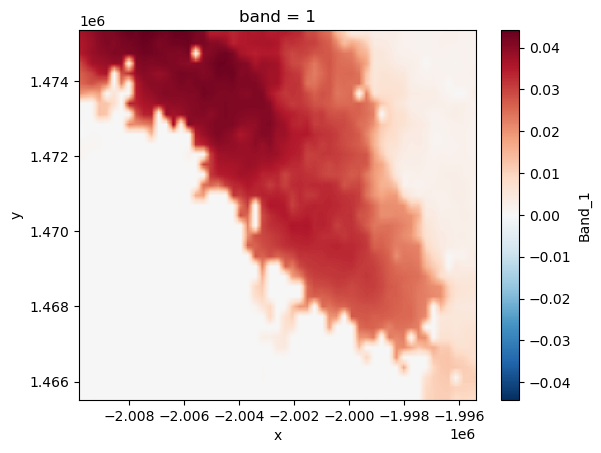

In [59]:
subset_30.BP.plot()

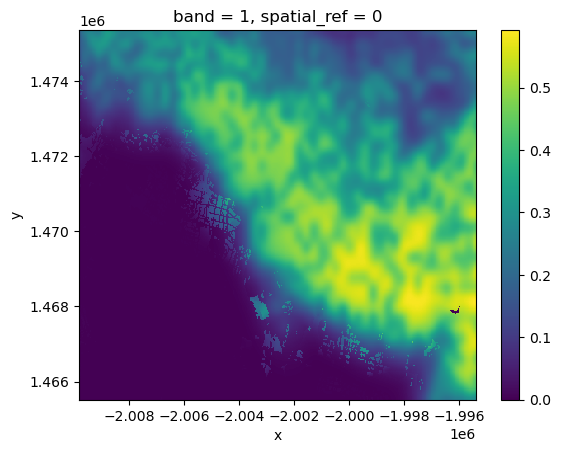

In [52]:
(1-((rps_30/100-1)**30)).plot()

In [99]:
selected_direction = 'NE'
wind_spread_da = all_direction_spreading(subset_30['BP'], iterations=3)[selected_direction]
focal_mean_spread_da = all_direction_spreading(subset_30['BP'], iterations=3)['circular']

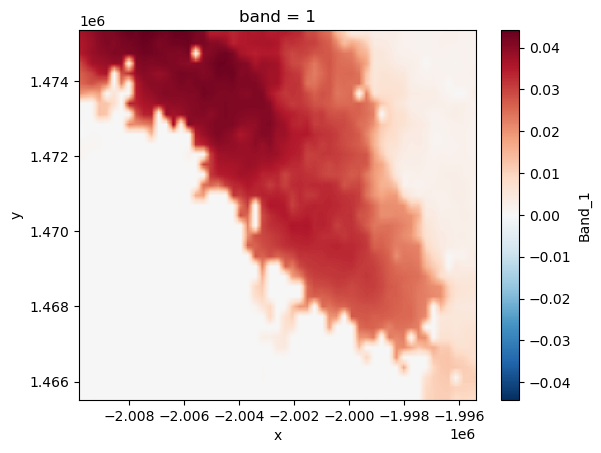

In [94]:
subset_30['BP'].plot()

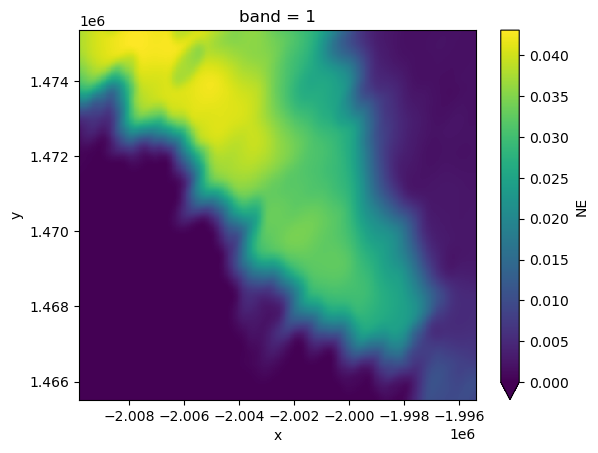

In [103]:
wind_spread_da.plot(vmin=0)

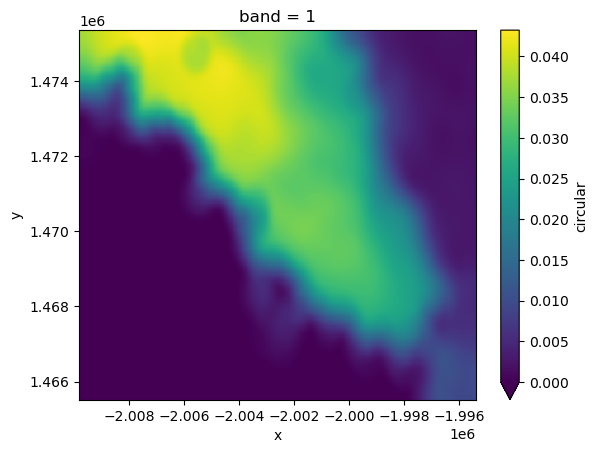

In [104]:
focal_mean_spread_da.plot(vmin=0)

<Axes: title={'center': 'wind_spread'}, xlabel='x', ylabel='y'>

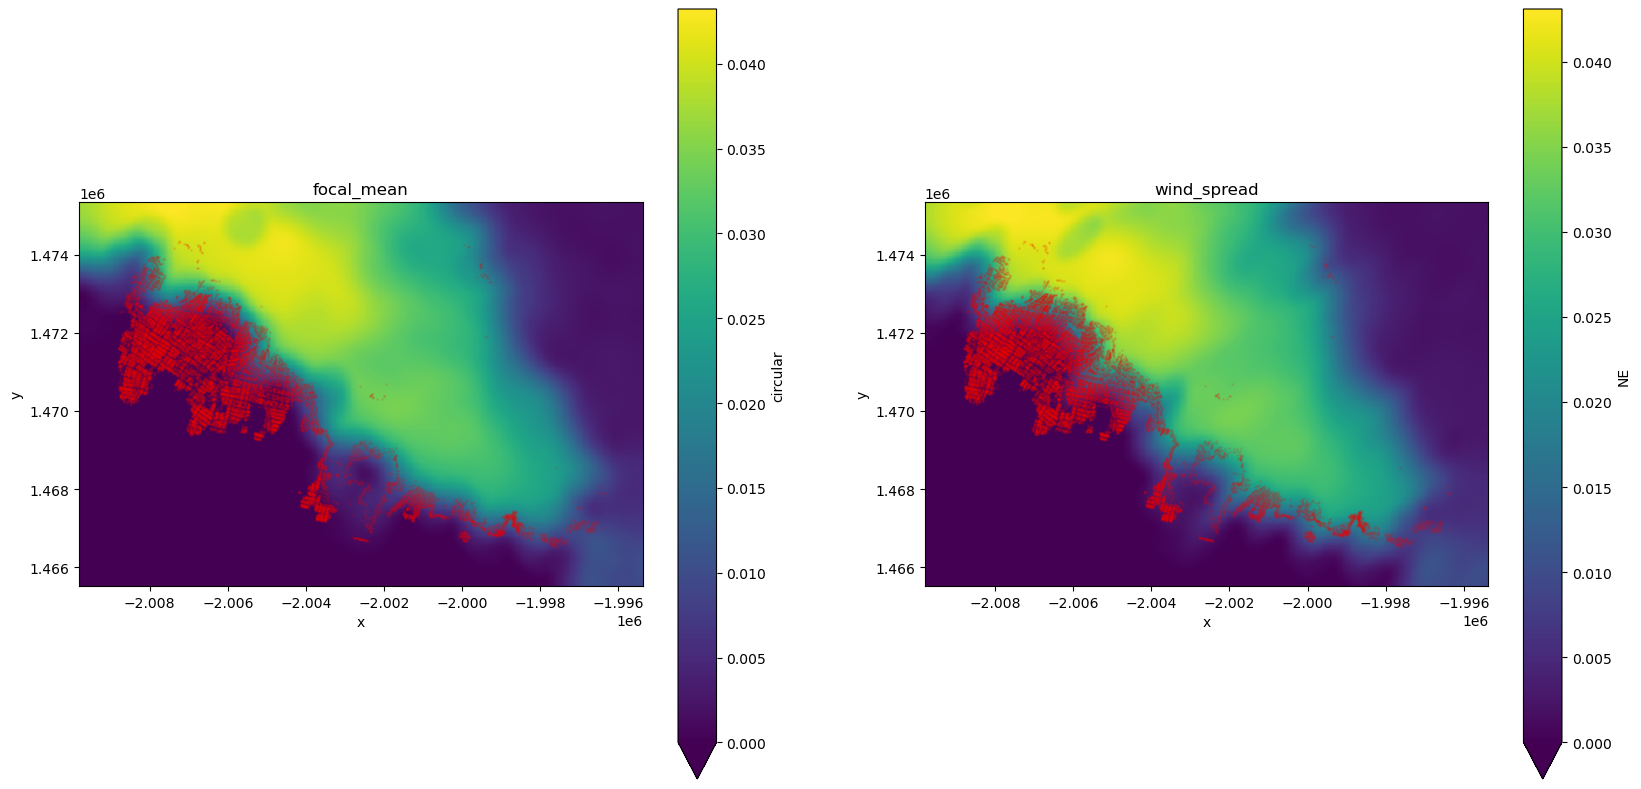

In [109]:
fig, axarr = plt.subplots(figsize=(20, 10), ncols=2)
focal_mean_spread_da.plot(ax=axarr[0], vmin=0)
axarr[0].set_title('focal_mean')
eaton.plot(ax=axarr[0], color='red', alpha=0.1, markersize=1)
wind_spread_da.plot(ax=axarr[1], vmin=0)
axarr[1].set_title('wind_spread')
eaton.plot(ax=axarr[1], color='red', alpha=0.1, markersize=1)


In [123]:
def extract_point_data(gdf, ds, label):
    # Apply a function to each geometry (point) in gdf to retrieve the value from ds
    gdf[label] = gdf['geometry'].apply(
        lambda point: ds.sel(y=point.y, x=point.x, method='nearest').values.item()
    )
    return gdf

In [118]:
eaton[0:2]

,OBJECTID,GLOBALID,DAMAGE,STRUCTURET,geometry
0,1,da82e80c-ada4-4e58-9a42-07b20e48b868,No Damage,Single Family Residence Multi Story,POINT (-2003492.180 1468519.526)
1,2,a6839b8e-157a-41fb-8aab-b35095b1e4ea,No Damage,Single Family Residence Multi Story,POINT (-2004623.988 1470014.211)


In [124]:
eaton = extract_point_data(eaton, focal_mean_spread_da, 'focal_mean_spread')

In [126]:
eaton = extract_point_data(eaton, wind_spread_da, 'wind_spread')

(array([13428.,  1723.,  1372.,   897.,   517.,   271.,   130.,    36.,
           20.,    30.]),
 array([-1.18423789e-17,  4.06726054e-03,  8.13452107e-03,  1.22017816e-02,
         1.62690421e-02,  2.03363027e-02,  2.44035632e-02,  2.84708237e-02,
         3.25380843e-02,  3.66053448e-02,  4.06726054e-02]),
 <BarContainer object of 10 artists>)

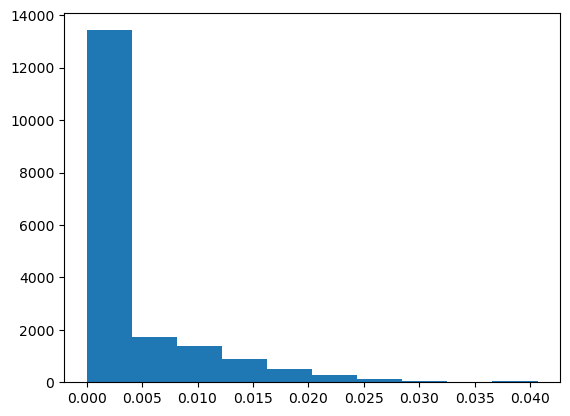

In [127]:
plt.hist(eaton['focal_mean_spread'].values)

(array([9642., 2031., 1579., 1295., 1330., 1125.,  641.,  489.,  239.,
          53.]),
 array([-1.00462294e-06,  4.13287021e-03,  8.26674504e-03,  1.24006199e-02,
         1.65344947e-02,  2.06683695e-02,  2.48022444e-02,  2.89361192e-02,
         3.30699940e-02,  3.72038688e-02,  4.13377437e-02]),
 <BarContainer object of 10 artists>)

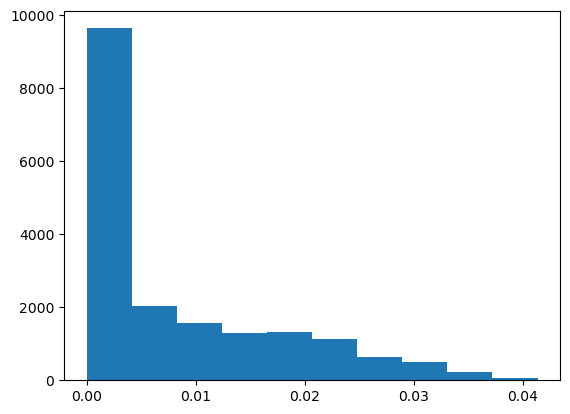

In [128]:
plt.hist(eaton['wind_spread'].values)

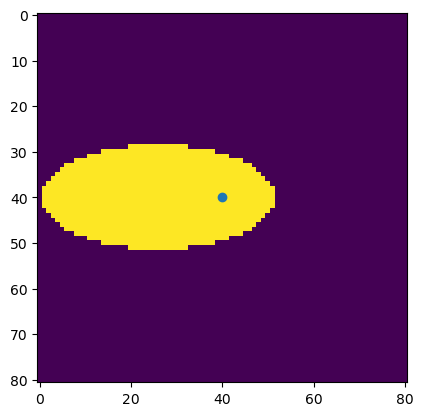

In [67]:
plt.imshow(load_weights('wind_skewed'))
plt.scatter(40,40)

In [ ]:
# Load up the ERA5 winds for a single location

In [ ]:
important_days = xr.open_zarr('s3://carbonplan-risks/era5/fire_weather_days_v2.zarr')

In [ ]:
# Plot wind rose

In [ ]:
# load in the 270m risk

In [ ]:
# select the box around palisades

In [ ]:
# apply the filter

In [ ]:
# load in WRC 2024 30m California 
# Plot subset over Palisades

In [ ]:
# compare the performance of the two approaches (wind-smeared and uniformly smeared)
# how to measure performance?


In [ ]:
lat = 34.17
lon = -118.09
important_days_to_plot = lon_to_180(important_days).sel(latitude=lat, longitude=lon, method='nearest').compute()
fig, ax = plot_windrose(important_days_to_plot['sfcWindfromdir'], important_days_to_plot['10m_wind_gust_since_previous_post_processing'], bins=np.arange(15, 20, 0.5))
fig.suptitle(f'{lat}, {lon}')